# Introduction
This will be used do the visualisation of the different variables

In [1]:
from pyspark.sql import SparkSession

In [2]:
# Créer la session Spark
spark = SparkSession.builder.appName("movie_process") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/03 16:11:04 WARN Utils: Your hostname, Batman, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/07/03 16:11:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 16:11:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 16:11:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 16:11:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [ ]:
df_movies = spark.read.csv("../data/processed/movies_processed.csv", header=True, inferSchema=True) # Seulement movies a été processed à ce stade
df_links = spark.read.csv("../data/raw/links.csv", header=True, inferSchema=True)
df_ratings = spark.read.csv("../data/raw/ratings.csv", header=True, inferSchema=True)
df_tags = spark.read.csv("../data/raw/tags.csv", header=True, inferSchema=True)
df_movies2 = spark.read.csv("../data/processed/movies_exploded.csv", header=True, inferSchema=True)

In [10]:
df_movies.show(5)
df_links.show(5)
df_ratings.show(5)
df_tags.show(5)
df_movies2.show(5)

+-------+--------------------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+---------------------------------+------------------+----+------+-------+------+--------+------+------+
|movieId|               title|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|We're Comin' To Get Ya!"" (2014)"|(no genres listed)|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+--------------------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+---------------------------------+------------------+----+------+-------+------+--------+------+------+
|      1|    Toy Story (1995)|Adventure|Animati...|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        1|        0|                                0|                 0|   0|     0|      0|     1|       1

In [14]:
# Faire la jointure entre df_movies2 et df_ratiings
df_movies_ratings = df_movies2.join(df_ratings, df_movies2.movieId == df_ratings.movieId, "left") \
    .select(df_movies2["*"], df_ratings["rating"])

# Afficher les 5 premières lignes du DataFrame résultant
df_movies_ratings.show(5)

+-------+--------------------+-----------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+---------------------------------+------------------+----+------+-------+------+--------+------+------+-----+------+
|movieId|               title|     genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|We're Comin' To Get Ya!"" (2014)"|(no genres listed)|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|genre|rating|
+-------+--------------------+-----------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+---------------------------------+------------------+----+------+-------+------+--------+------+------+-----+------+
| 104064|Vares: The Path o...|Crime|Drama|    1|      0|       0|        0|    1|  0|          0|      0|      0|      0|        0|        0|                                0|                 0|   0|     0|      0|     0|     

In [25]:
from pyspark.sql import functions as F

df_stats_by_genre = (
    df_movies_ratings
    .groupBy("genre")
    .agg(
        F.avg("rating").alias("average_rating"),
        F.count("rating").alias("count_ratings")
    )
    .orderBy(F.desc("count_ratings"))  # Trie par nombre de ratings, optionnel
)

df_stats_by_genre.show(truncate=False)

+------------------+------------------+-------------+
|genre             |average_rating    |count_ratings|
+------------------+------------------+-------------+
|Drama             |3.6824540581800784|13973271     |
|Comedy            |3.4323858239436777|11206925     |
|Action            |3.476407141777424 |9665213      |
|Thriller          |3.5317020152396505|8679464      |
|Adventure         |3.5234385724723545|7590522      |
|Sci-Fi            |3.4916991949223912|5717337      |
|Romance           |3.5450028644529983|5524615      |
|Crime             |3.6917711184948736|5373051      |
|Fantasy           |3.512174705402107 |3702759      |
|Children          |3.4392409733948646|2731841      |
|Mystery           |3.673102967818112 |2615322      |
|Horror            |3.3071549944529486|2492315      |
|Animation         |3.6153322869262636|2214562      |
|War               |3.7916994435766664|1594110      |
|IMAX              |3.593312447839248 |1494179      |
|Musical           |3.554276

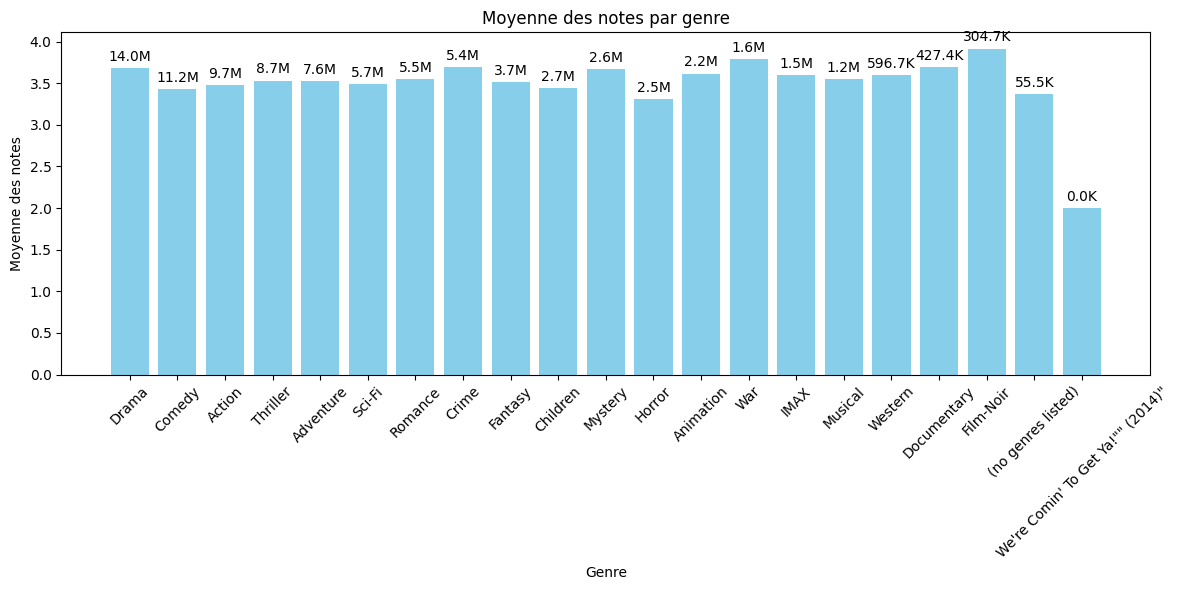

In [26]:
# plotter la moyenne des notes par genre sur matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Convertir le DataFrame Spark en DataFrame Pandas
df_genre_ratings_pd = df_stats_by_genre.toPandas()

# Tracer la moyenne des notes par genre
plt.figure(figsize=(12, 6))
bars = plt.bar(df_genre_ratings_pd["genre"], df_genre_ratings_pd["average_rating"], color='skyblue')
plt.xlabel("Genre")
plt.ylabel("Moyenne des notes")
plt.title("Moyenne des notes par genre")
plt.xticks(rotation=45)

# Ajouter le nombre de ratings par millier (K) ou par millions (M) en haut des barres
for i, bar in enumerate(bars):
    count = df_genre_ratings_pd["count_ratings"][i]
    if count >= 1000000:
        count_text = f"{count/1000000:.1f}M"  # Format en millions
    else:
        count_text = f"{count/1000:.1f}K"  # Format en milliers
    
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             count_text, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# La coefficient de Wilson

In [ ]:
import pandas as pd
import numpy as np

# df : DataFrame contenant ['genre', 'rating']

# Créer la colonne des votes positifs
df_genre_ratings_pd['positive'] = (df_genre_ratings_pd['rating'] >= 4).astype(int)

# Grouper par genre
df_genre_ratings_pd_grouped = df_genre_ratings_pd.groupby('genre').agg(
    n=('rating', 'count'),
    k=('positive', 'sum'),
    average_rating=('rating', 'mean')
).reset_index()

# Fonction Wilson
def wilson_lower_bound(k, n, z=1.96):
    if n == 0:
        return 0
    p = k / n
    denominator = 1 + z**2 / n
    center = p + z**2 / (2*n)
    margin = z * np.sqrt((p*(1-p)/n) + (z**2)/(4*n**2))
    return (center - margin) / denominator

df_genre_ratings_pd_grouped['wilson_lb'] = df_genre_ratings_pd_grouped.apply(lambda row: wilson_lower_bound(row['k'], row['n']), axis=1)
df_genre_ratings_pd_grouped = df_genre_ratings_pd_grouped.sort_values('wilson_lb', ascending=False)

print(df_genre_ratings_pd_grouped[['genre', 'n', 'k', 'average_rating', 'wilson_lb']])


{"ts": "2025-07-03 17:03:18.347", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `rating` cannot be resolved. Did you mean one of the following? [`genre`, `positive`, `count_ratings`, `average_rating`]. SQLSTATE: 42703", "context": {"file": "jdk.internal.reflect.GeneratedMethodAccessor93.invoke(Unknown Source)", "line": "", "fragment": "col", "errorClass": "UNRESOLVED_COLUMN.WITH_SUGGESTION"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o373.agg.\n: org.apache.spark.sql.AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `rating` cannot be resolved. Did you mean one of the following? [`genre`, `positive`, `count_ratings`, `average_rating`]. SQLSTATE: 42703;\n'Aggregate [genre#612], [genre#612, 'count('rating) AS n#1422, sum(positive#1421) AS k#1423L, 'avg('rating) AS average_rating#1424]\n+

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `rating` cannot be resolved. Did you mean one of the following? [`genre`, `positive`, `count_ratings`, `average_rating`]. SQLSTATE: 42703;
'Aggregate [genre#612], [genre#612, 'count('rating) AS n#1422, sum(positive#1421) AS k#1423L, 'avg('rating) AS average_rating#1424]
+- Project [genre#612, average_rating#1340, count_ratings#1341L, CASE WHEN (average_rating#1340 >= cast(4 as double)) THEN 1 ELSE 0 END AS positive#1421]
   +- Sort [count_ratings#1341L DESC NULLS LAST], true
      +- Aggregate [genre#612], [genre#612, avg(rating#548) AS average_rating#1340, count(rating#548) AS count_ratings#1341L]
         +- Project [movieId#588, title#589, genres#590, Crime#591, Romance#592, Thriller#593, Adventure#594, Drama#595, War#596, Documentary#597, Fantasy#598, Mystery#599, Musical#600, Animation#601, Film-Noir#602, We're Comin' To Get Ya!"" (2014)"#603, (no genres listed)#604, IMAX#605, Horror#606, Western#607, Comedy#608, Children#609, Action#610, Sci-Fi#611, genre#612, ... 1 more fields]
            +- Join LeftOuter, (movieId#588 = movieId#547)
               :- Relation [movieId#588,title#589,genres#590,Crime#591,Romance#592,Thriller#593,Adventure#594,Drama#595,War#596,Documentary#597,Fantasy#598,Mystery#599,Musical#600,Animation#601,Film-Noir#602,We're Comin' To Get Ya!"" (2014)"#603,(no genres listed)#604,IMAX#605,Horror#606,Western#607,Comedy#608,Children#609,Action#610,Sci-Fi#611,genre#612] csv
               +- Relation [userId#546,movieId#547,rating#548,timestamp#549] csv
